<a href="https://colab.research.google.com/github/DawidP2001/MLPortfolio/blob/main/DecisionTrees_IncomePredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


# **Introudction**
In this project I'm going to show how I use decision trees. The data set i use is Adult census income. It is a collection of records from the 1994 census in the US. You can have a look at the dataset [here](https://www.kaggle.com/datasets/uciml/adult-census-income). In this project I will try to make an algorithm that would be able to predict whether a certain person was earning under or over $50,000 a year based on certain characteristics.

---




# **Table of Contents**


---



#  **DataSet**




---


## **Dataset Download**
Directly below I show how I directly access the data from keggle without downloading it manually onto my local machine first.

In [4]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"dawidpionk","key":"ca3f41696a489f42942bb464285ea394"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d uciml/adult-census-income

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/uciml/adult-census-income
License(s): CC0-1.0
adult-census-income.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! mkdir adult-census-income
! unzip adult-census-income.zip -d adult-census-income

Archive:  adult-census-income.zip
  inflating: adult-census-income/adult.csv  


Below I just extract the data from the file

In [7]:
import csv
import pandas as pd
import numpy as np
data = pd.read_csv('adult-census-income/adult.csv')

data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K




---


## **Data Preprocessing**
Below I Remove all the rows with a missing entry. Only the workclass, occupation and native country had missing entries so I just use the drop method on them.

In [8]:
data.drop(data[data['workclass'] == '?'].index, inplace = True)
data.drop(data[data['occupation'] == '?'].index, inplace = True)
data.drop(data[data['native.country'] == '?'].index, inplace = True)

Below I prepare the data to be used by the algorithm. Since the decision tree algorithm can only use numerical data, I converted all the categorical entries into numerical values inside a map data structure.

### workclass Column

In [9]:
data['workclass'].unique() # Check what are the unique values for the
                           # workclass column

array(['Private', 'State-gov', 'Federal-gov', 'Self-emp-not-inc',
       'Self-emp-inc', 'Local-gov', 'Without-pay'], dtype=object)

In [10]:
# dataToMap stores the map that will replace the entries on the data frame
dataToMap = {
    'Private': 0,
    'State-gov': 1,
    'Federal-gov': 2,
    'Self-emp-not-inc': 3, # Self-employed, not incorporated
    'Self-emp-inc': 4,     # Self-employed, incorporated
    'Local-gov': 5,
    'Without-pay': 6,
    'Never-worked': 7
    }
data['workclass'] = data['workclass'].map(dataToMap)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,0,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,0,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,0,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,0,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,0,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


### education Column

In [11]:
data['education'].unique() # Check what are the unique values for the
                           # workclass column

array(['HS-grad', '7th-8th', 'Some-college', '10th', 'Doctorate',
       'Prof-school', 'Bachelors', 'Masters', '11th', 'Assoc-voc',
       '1st-4th', '5th-6th', 'Assoc-acdm', '12th', '9th', 'Preschool'],
      dtype=object)

In [12]:
dataToMap = {
    'HS-grad': 0,
    '7th-8th': 1,
    'Some-college': 2,
    '10th': 3,
    'Doctorate': 4,
    'Prof-school': 5,
    'Bachelors': 6,
    'Masters': 7,
    '11th': 8,
    'Assoc-voc': 9,
    '1st-4th': 10,
    '5th-6th': 11,
    'Assoc-acdm': 12,
    '12th': 13,
    '9th': 14,
    'Preschool': 15
    }
data['education'] = data['education'].map(dataToMap)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,0,132870,0,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,0,140359,1,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,0,264663,2,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,0,216864,0,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,0,150601,3,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


### Marital Status

In [13]:
data['marital.status'].unique() # Check what are the unique values for the
                                # marital status column

array(['Widowed', 'Divorced', 'Separated', 'Never-married',
       'Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse'],
      dtype=object)

In [14]:
dataToMap = {
    'Widowed': 0,
    'Divorced': 1,
    'Separated': 2,
    'Never-married': 3,
    'Married-civ-spouse': 4,
    'Married-spouse-absent': 5,
    'Married-AF-spouse': 6
    }
data['marital.status'] = data['marital.status'].map(dataToMap)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,0,132870,0,9,0,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,0,140359,1,4,1,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,0,264663,2,10,2,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,0,216864,0,9,1,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,0,150601,3,6,2,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K


### Sex

In [15]:
data['sex'].unique() # Check what are the unique values for the
                     # sex column

array(['Female', 'Male'], dtype=object)

In [16]:
dataToMap = {
    'Female': 0,
    'Male': 1,
    }
data['sex'] = data['sex'].map(dataToMap)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,0,132870,0,9,0,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,<=50K
3,54,0,140359,1,4,1,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,<=50K
4,41,0,264663,2,10,2,Prof-specialty,Own-child,White,0,0,3900,40,United-States,<=50K
5,34,0,216864,0,9,1,Other-service,Unmarried,White,0,0,3770,45,United-States,<=50K
6,38,0,150601,3,6,2,Adm-clerical,Unmarried,White,1,0,3770,40,United-States,<=50K


### Income Column

In [17]:
data['income'].unique() # Check what are the unique values for the
                        # income column

array(['<=50K', '>50K'], dtype=object)

In [18]:
dataToMap = {
    '<=50K': 0,
    '>50K': 1,
    }
data['income'] = data['income'].map(dataToMap)
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,0,132870,0,9,0,Exec-managerial,Not-in-family,White,0,0,4356,18,United-States,0
3,54,0,140359,1,4,1,Machine-op-inspct,Unmarried,White,0,0,3900,40,United-States,0
4,41,0,264663,2,10,2,Prof-specialty,Own-child,White,0,0,3900,40,United-States,0
5,34,0,216864,0,9,1,Other-service,Unmarried,White,0,0,3770,45,United-States,0
6,38,0,150601,3,6,2,Adm-clerical,Unmarried,White,1,0,3770,40,United-States,0




---



# **Decision Tree Algorithm**
Decision Tree is a machine learning model in which the data is split into smaller subsets based on certain criteria depending on the model. This process is repeated over and over again until you can't reduce the data anymore.

Decision Trees can be used for both classification and regression tasks. **Classification Task** is when you try to predict a **categorical value**. **Regressiion Task** is when you try to predict a **continuous value**. Since I am trying to predict whether a person earns more or less than 50k I am working on a classifcation task.

To learn about this subject I used the following resources: [w3schools](https://www.w3schools.com/python/python_ml_decision_tree.asp), chatGPT

Below I show how I use a decision tree algorithm on my dataset. For this task I used the scikit-learn library, which implements a decision tree type called CART.


### Decision Tree setup and data Visualisation

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

[Text(0.5288461538461539, 0.9, 'marital.status <= 3.5\ngini = 0.374\nsamples = 30162\nvalue = [22654, 7508]'),
 Text(0.3076923076923077, 0.7, 'marital.status <= 1.5\ngini = 0.127\nsamples = 15706\nvalue = [14638, 1068]'),
 Text(0.4182692307692308, 0.8, 'True  '),
 Text(0.15384615384615385, 0.5, 'sex <= 0.5\ngini = 0.189\nsamples = 5041\nvalue = [4509, 532]'),
 Text(0.07692307692307693, 0.3, 'marital.status <= 0.5\ngini = 0.125\nsamples = 3215\nvalue = [3000, 215]'),
 Text(0.038461538461538464, 0.1, 'gini = 0.112\nsamples = 686\nvalue = [645, 41]'),
 Text(0.11538461538461539, 0.1, 'gini = 0.128\nsamples = 2529\nvalue = [2355, 174]'),
 Text(0.23076923076923078, 0.3, 'marital.status <= 0.5\ngini = 0.287\nsamples = 1826\nvalue = [1509, 317]'),
 Text(0.19230769230769232, 0.1, 'gini = 0.4\nsamples = 141\nvalue = [102, 39]'),
 Text(0.2692307692307692, 0.1, 'gini = 0.276\nsamples = 1685\nvalue = [1407, 278]'),
 Text(0.46153846153846156, 0.5, 'sex <= 0.5\ngini = 0.095\nsamples = 10665\nvalue = 

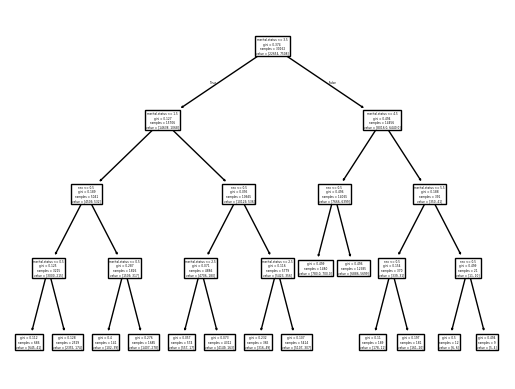

In [20]:
import pandas
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# features are the categories that the model will be trained on.
features = ['marital.status', 'sex']

X = data[features]
y = data['income']

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)

tree.plot_tree(dtree, feature_names=features)

As you can see the ouput from the plot is too small to read. So below I try out different methods to try to make the nodes more visible

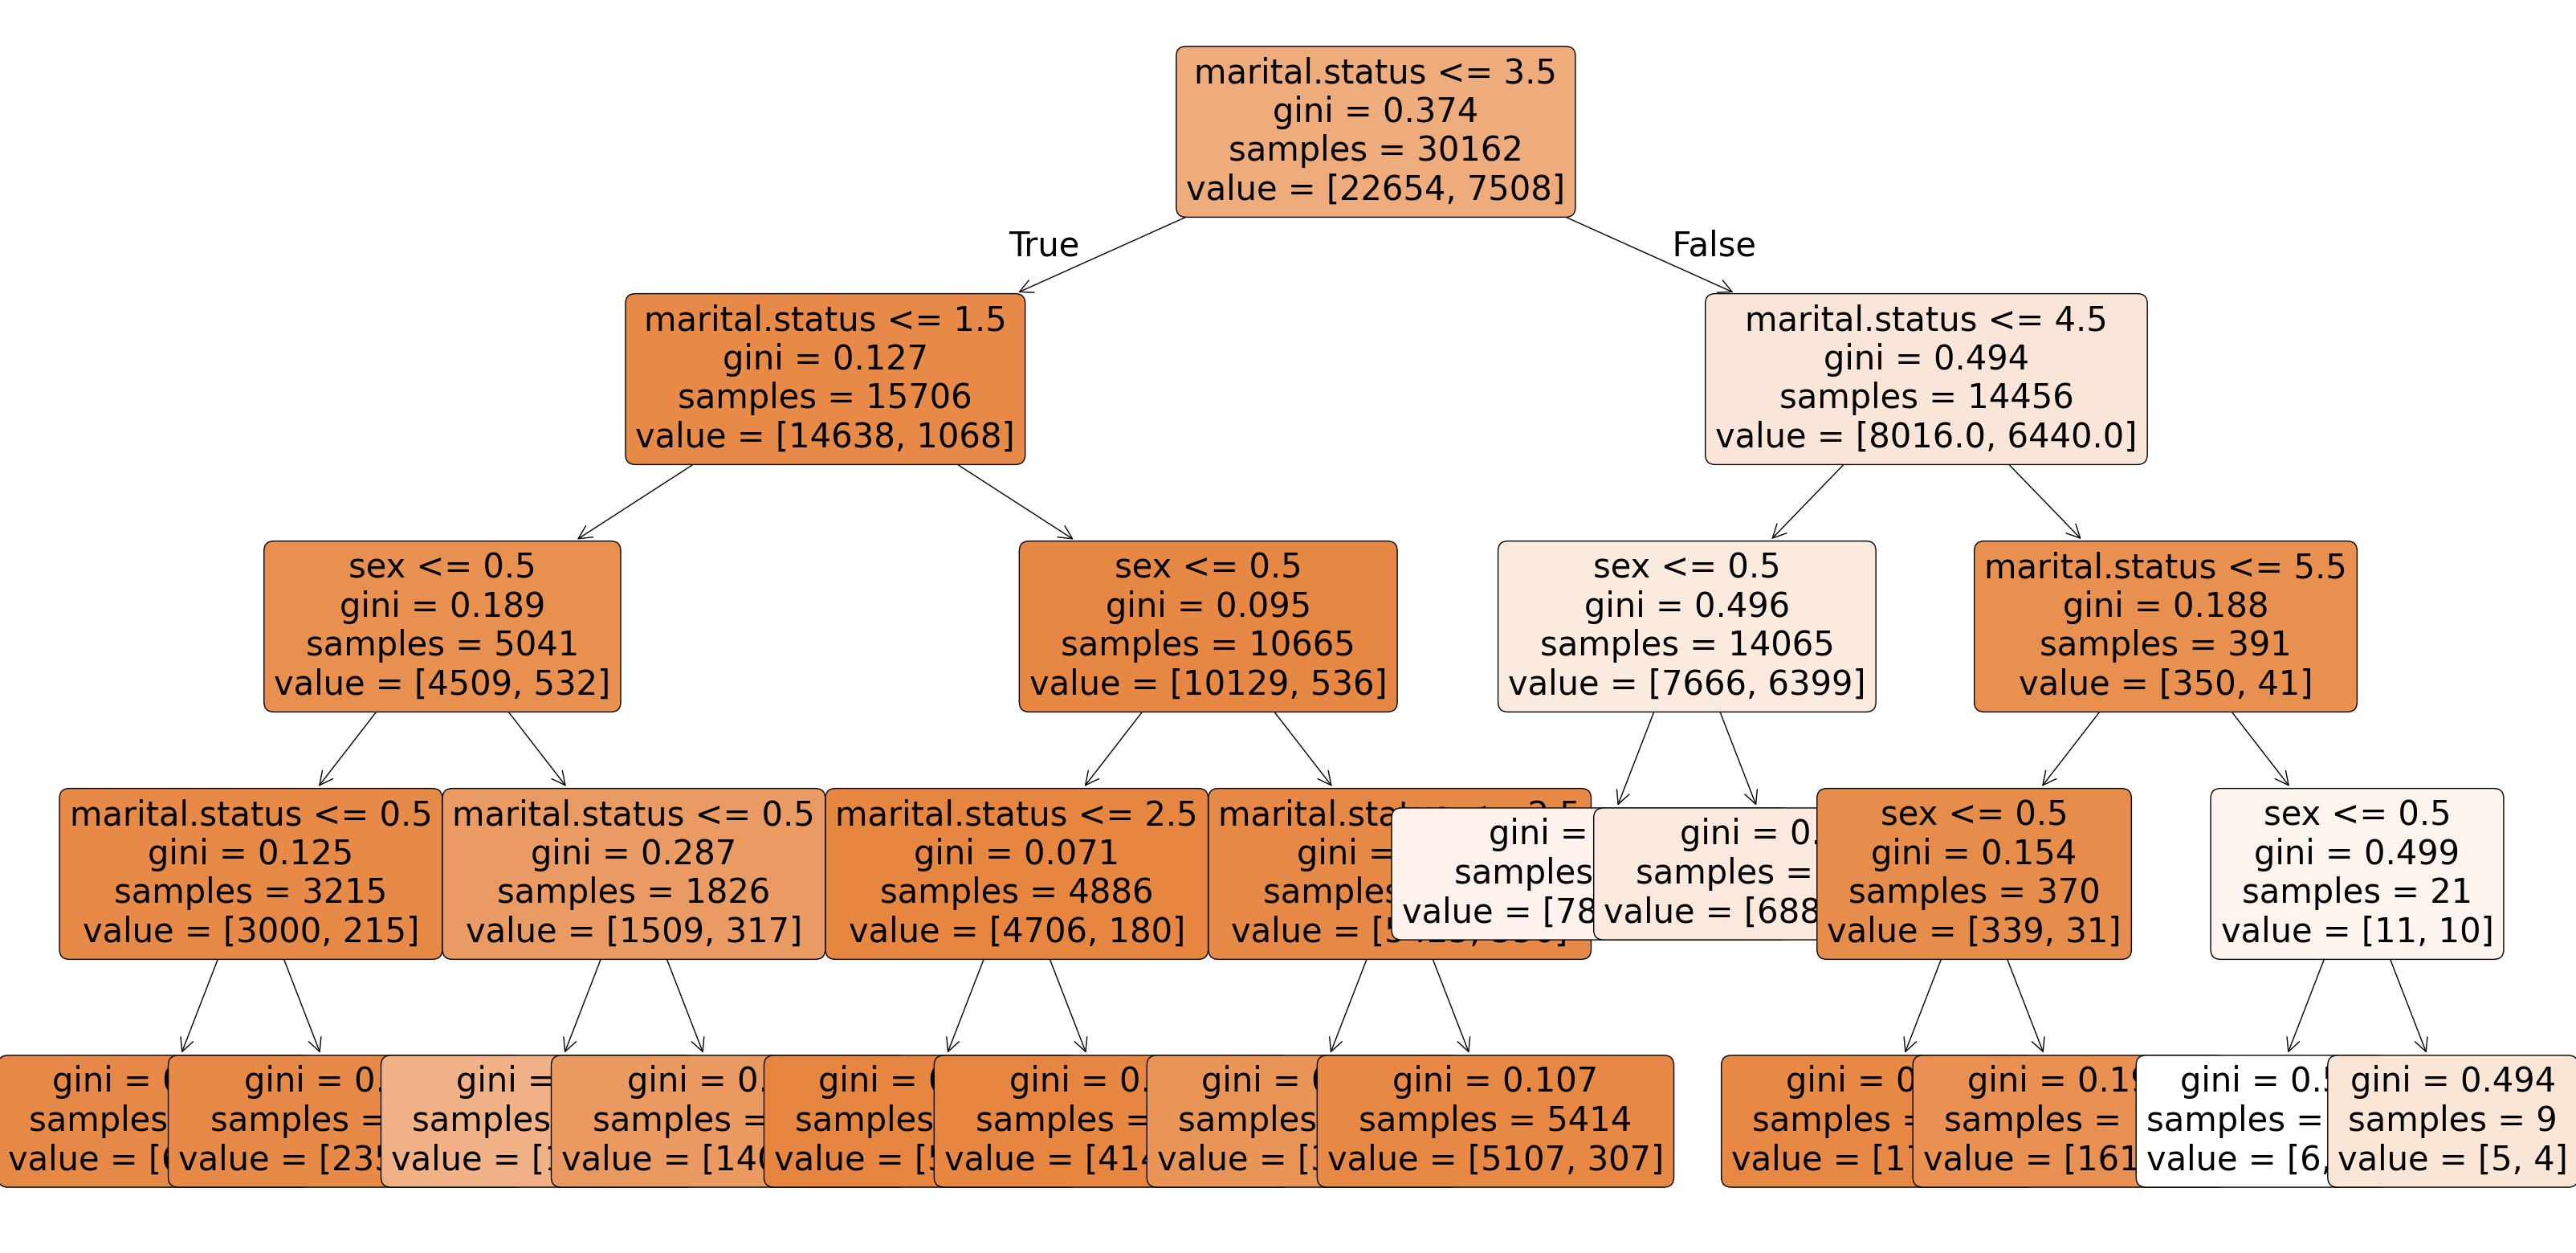

In [21]:
plt.figure(figsize=(40, 20))  # Adjust width and height as needed
tree.plot_tree(
    dtree,
    feature_names=features,
    filled=True,
    rounded=True,
    fontsize=30
    )
plt.show()

As you can see above the graph is still pretty squished. When I try to make the graph larger the nodes themseleves become smaller and more difficult to read, so I assume this an issue with juptyter notebook and how it displays larger charts.

### Predictions and accuracy

Below I try to figure out how to gauge how accurate the model above is. I used the following source for this section: [datacamp](https://www.datacamp.com/tutorial/decision-tree-classification-python?dc_referrer=https%3A%2F%2Fwww.google.com%2F)

In [22]:
from sklearn import metrics
y_pred = dtree.predict(X)
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.7510775147536636


The accuracy is 75% which is a pretty good accuracy, so the model is quite useful at predicting whether an adults income is above 50k. How I could potentially make the model accurate is by adding additional x variables. As you can see in the preprocessing section I made the columns workclass and education suitable to be used for model training. Below I add those additional variables to see if it could potentially increase the accuracy of this model.

In [23]:
# as you can see I added workforce and education to the independent variables
features = ['workclass', 'education', 'marital.status', 'sex']

X = data[features]
y = data['income']

dtree = DecisionTreeClassifier()
dtree = dtree.fit(X, y)
y_pred = dtree.predict(X)
print("Accuracy:",metrics.accuracy_score(y, y_pred))

Accuracy: 0.8236522777004177


As you can see addition of those 2 variables increased the accuracy quite significantly, from 75% to 82%.



---


# **Testing Sets**
In this section I try to learn how the concept of Test sets works in data science. I used this resource for this purpose: [w3schools](https://www.w3schools.com/python/python_ml_train_test.asp).

Below I set up a scatter graph with 2 random variables just to visually show the difference between the full data, testing data and training data sets.

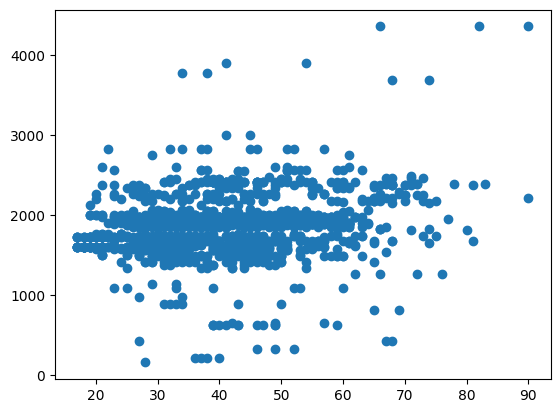

In [24]:
data = pd.read_csv('adult-census-income/adult.csv')
processedData = data[data['capital.loss']>0] # Just removed all the rows that
                                             # had no capital loss
x = processedData['age']
y = processedData['capital.loss']
plt.scatter(x, y)

Train/Test is a method in machine learning in which you split your data set into to groups, the training set and testing set. The training set is 80% of your overall data and is responsible for training your model, meanwhile testing data is 20% of your overall data and is responsible for testing if your model was trained correctly.
Below you can see how I tried out this concept.

In [25]:
print(x.count())

1519


As you can see above there are 1519 rows in my dataset. So 1215 rows should be within the training set and 304 should be within the testing set.

In [26]:
train_x = x[:1215]
train_y = y[:1215]

test_x = x[1215:]
test_y = y[1215:]
print(train_x.count())
print(test_x.count())

1215
304


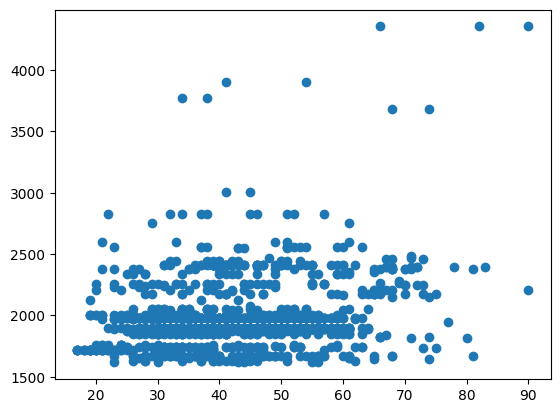

In [27]:
plt.scatter(train_x, train_y)
plt.show()

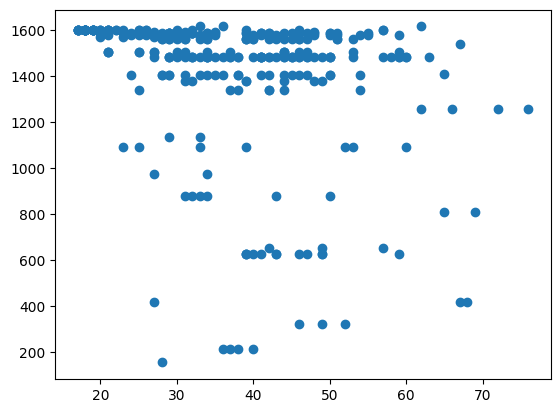

In [28]:
plt.scatter(test_x, test_y)
plt.show()

Above you can see the difference between the two sets. Also you can see that the data is very different in the two graphs. The data in the training set only contains values above rougly 2000 while in the tesing set its all under 2000, which suggests the data was sorted. This issue can probably be fixed by randomising the set, below I attempt this to see if it fixed the issues.

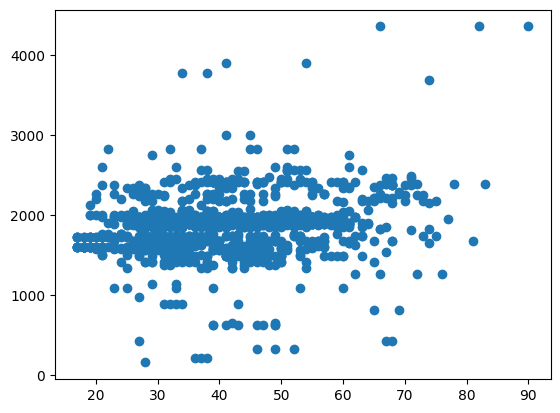

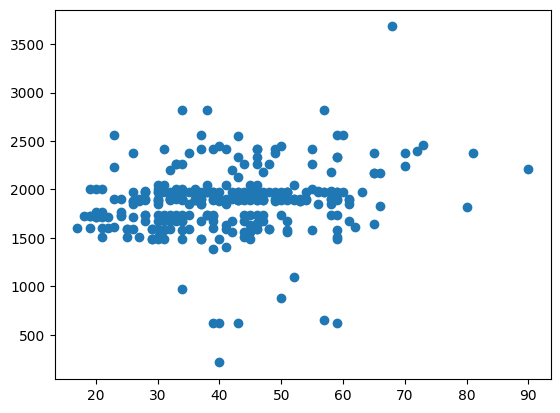

In [29]:
data = pd.read_csv('adult-census-income/adult.csv')
data = data.sample(n=len(data))
processedData = data[data['capital.loss']>0]
x = processedData['age']
y = processedData['capital.loss']

train_x = x[:1215]
train_y = y[:1215]
test_x = x[1215:]
test_y = y[1215:]

plt.scatter(train_x, train_y)
plt.show()
plt.scatter(test_x, test_y)
plt.show()

Both of the data sets have rougly the similar layouts that means the issue was resolved.

## Applying Testing sets to Decision Trees
Below I combine what I learned in the 2 previous sections.

In [30]:
data = pd.read_csv('adult-census-income/adult.csv')
data = data.sample(n=len(data))
x = data[['age','capital.loss']]
y = data['income']

train_x = x[:1215]
train_y = y[:1215]
test_x = x[1215:]
test_y = y[1215:]

dtree = DecisionTreeClassifier()
dtree = dtree.fit(train_x, train_y)
y_pred = dtree.predict(train_x)
print("Training Data Accuracy:",metrics.accuracy_score(train_y, y_pred))
y_pred = dtree.predict(test_x)
print("Testing Data Accuracy:",metrics.accuracy_score(test_y, y_pred))

Training Data Accuracy: 0.7777777777777778
Testing Data Accuracy: 0.7698908951700376


The two accuracy are values are pretty close together showing that the model is accurate.



---

# **Types of Decision Trees**
In the section I talk about different variants of decision trees. I also try to implement some of them on the census dataset. I used this resource to learn about this subject: [geeksforgeeks](https://www.geeksforgeeks.org/decision-tree-algorithms/) as well as [scikit-learn](https://scikit-learn.org/1.5/modules/tree.html)

## ID3 (Iterative Dichotomiser 3)
This type of decision tree is used for both classification and regression tasks. It mainly deals with with categorical properties which would make it better for this dataset. The decision trees produced by this algorithm are easy to read. However, it is susceptible to overfitting.

How it works is, the algorithm continuously splits up the data based on which feature provides the most information gain. **Information gain** is measured by how much uncertainty (**entropy**) is reduced when the data is split. This cycle goes on until the data is split into pure groups with no more possible iterations.

I used these sources to learn more about this decision tree variant: [Youtube](https://www.youtube.com/watch?v=ZVR2Way4nwQ&ab_channel=NormalizedNerd),  [geeksforgeeks](https://www.geeksforgeeks.org/sklearn-iterative-dichotomiser-3-id3-algorithms/), as well a ChatGPT

Note: sklearn doesn't have a build in ID3 model so i will use the geeksforgeeks source and ChatGPT to make one.

###Calculating Entropy

In [ ]:

def calculate_entropy(data, target_column):
    total_rows = len(data)
    target_values = data[target_column].unique()

## C4.5
C4.5 is an enhancement to the ID3 algorithm. This model solves several issues of ID3, namely the issue of overfitting and not being able to work with continuous characteristics. Instead of using the information gain metric, C4.5 uses a modification of it called the **gain ratio**. It addresses the bias towards qualities with many values.

How it is able to work with continous values is, it sorts the columns values first and selects a midpoint between each value in the column. Then it calculates the gain ratio for each midpoint (**split point**). Then the midpoint with the highest gain ratio is selected, as a node. This process is repeated until you reach purity in all end nodes.

How it fixed the overfitting issue is through a process called **pruning**. How pruning works is when the tree is fully built the model checks if any branches can be removed without significantly affecting the models accuracy.

## CART (Classification and Regression Trees)


## CHAID (Chi-Square Automatic Interaction Detection)